## Attacking MNIST Dataset

Here we use a custom NN trained on MNIST data to perform *zero order Stochastic Gradient Descent*

**1. Set current directory**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd /content/gdrive/My Drive/Colab Notebooks/Adversarial/AdvAttack/src

**2. Import libraries**

In [4]:
import src.loss as customLoss
import src.zeroOptim as zeroOptim
import src.dataset as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
from torchvision import transforms
from torch import nn, optim
from src.models import MnistNet

**3. Retrieve MNIST data**

We retrieve the MNIST data. <br>
The 'standard' *trasnform.compose* method just convert the data to *torch.Tensor* without any rescaling or normalizzation


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


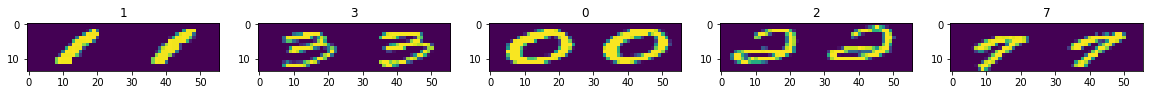

In [2]:
DataLoader = data.MNIST(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
DataLoader.get_info()

**4. Retrieve the network**

In [7]:
device = torch.device('cuda')
net = MnistNet().to(device)
net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))

<All keys matched successfully>

### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use the non-convex usage version of *Zero-order Stochastic Conditional Gradient with Inexact Updates* to modify the image in order to make the network be mistaken.

We can set an epsilon as an upper bound for the inifinity norm of our input.

**Args:**

        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        mk:             (list)              Number of normal vector to generate at every step
        gamma_k         (list)              Pseudo learning rate inside ICG at every step
        mu_k            (list)              Stopping criterion inside ICG at every step
        epsilon:        (float)             The upper bound of the infinity norm
        C:              (tuple)             The boundaires of the pixel. Default is (0, 1)
        max_steps:      (int)               The maximum number of steps. Default is 100
        stop_criterion  (float)             The minimum loss function. Default is 1e-3
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False
        max_t           (int)               The maximum number of iteration inside of ICG

**Suggested values** <br>
*Zeroth-order Nonconvex Stochastic Optimization: Handling Constraints, High-Dimensionality and Saddle-Points* (rishnakumar Balasubramanian†1 and Saeed Ghadimi‡2):

$v = \sqrt{\frac{1}{2N(d+3)^3}}$, 
$\gamma_{k} =2L$,
$\mu_{k} = \frac{1}{4N}$
$m_{k} = 6(d + 5)N$,
$\forall k \geq 1$

where:<br>
- *N* is the number of steps <br>
- *d* is the dimension of *x* <br>
- *L* is the constant of the Lipschitz gradient of f

**E.G:** <br>
If we set $N = 100$, $L = 1$ and we have an image 28 * 28 ($d = 784$) we have: <br>

- $v = 3e-6$
- $\gamma_{k} = 2$
- $\mu_{k} = 0.0025$
- $m_{k} = 4734$

**N.B** <br>
-- TODO -- <br>
-- Set real values -- 

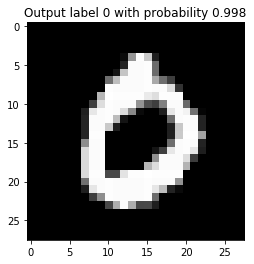

In [8]:
### Get an input used as test
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    break

net.eval()
img = X[3].cpu().numpy()
out = nn.Softmax(dim=1)(net(X[3].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out[0, original_label])))
plt.show()

**5.1 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

*E.g.* <br> 
We want to try to maximise the probability of classification of neuron *eight*



  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/500 [00:00<03:38,  2.29it/s]

  0%|▎                                                                                 | 2/500 [00:00<03:35,  2.31it/s]

  1%|▍                                                                                 | 3/500 [00:01<04:02,  2.05it/s]

  1%|▋                                                                                 | 4/500 [00:01<03:51,  2.14it/s]

  1%|▊                                                                                 | 5/500 [00:02<04:31,  1.82it/s]


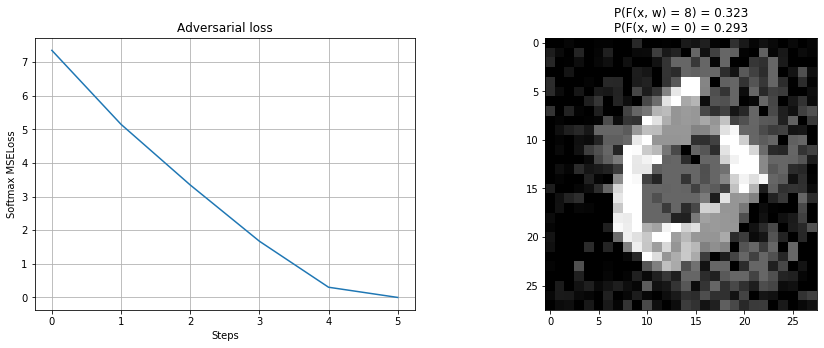

In [12]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=8, maximise=1)
adv_optimizer = zeroOptim.InexactZSCG(net, adv_loss, 'cuda')
### Run the optimizer
EPOCH = 500
x, loss, outs = adv_optimizer.run(X[3], 
                                  v               =  1, 
                                  mk              =  [28**2]*EPOCH, 
                                  gamma_k         =  [1]*EPOCH,
                                  mu_k            =  [0.1/(5*EPOCH)]*EPOCH,
                                  epsilon         =  0.4, 
                                  max_steps       =  EPOCH, 
                                  verbose         =  0, 
                                  additional_out  =  False,
                                  max_t           =  100)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('Softmax MSELoss')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),
                                                                             original_label, float(out[0, original_label])))
plt.show()

**5.2 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to manimize the probability of classification of neuron *zero*



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


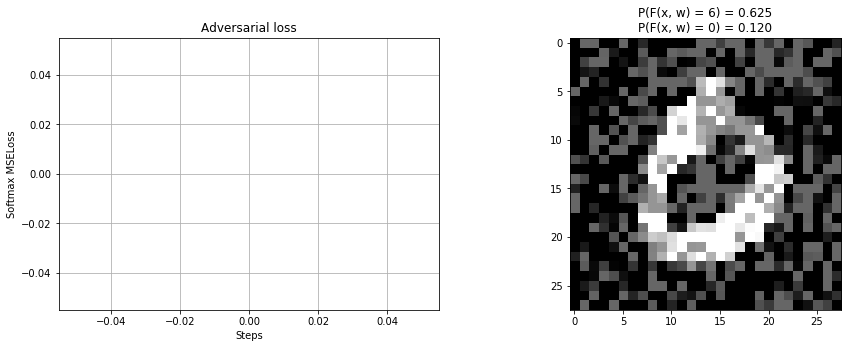

In [11]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=0, maximise=0)
adv_optimizer = zeroOptim.InexactZSCG(net, adv_loss, 'cuda')
### Run the optimizer
EPOCH = 100
x, loss, outs = adv_optimizer.run(X[3], 
                                  v               =  0.1, 
                                  mk              =  [28**2]*EPOCH, 
                                  gamma_k         =  [0.5]*EPOCH,
                                  mu_k            =  [1/(5*EPOCH)]*EPOCH,
                                  epsilon         =  0.4, 
                                  max_steps       =  EPOCH, 
                                  verbose         =  0, 
                                  additional_out  =  False,
                                  max_t           =  100)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('Softmax MSELoss')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),
                                                                             original_label, float(out[0, original_label])))
plt.show()

**Success rate at different infinity norm upper bound**

Here we can see how the algorithm perform when it goes from stricter to less strict epsilon with the first 10 validation images.

**BETTER ON COLAB**

In [ ]:
device = torch.device('cuda')
EPOCH = 100
def evaluate(e, n=7, mk=28**2, ak=0.8, v=0.2):
    X_test = X[:n, ...]
    success = []
    xs = []
    for x in tqdm(X_test):
        y_before = int(torch.argmax(net(x.to(device).view(1, 1, 28, 28))))
        loss = customLoss.MSELoss(neuron=y_before, maximise=0, dim=1)
        ADVoptim = zeroOptim.InexactZSCG(model=net, loss=loss, device=device)
        x_out, loss_curve, out =  ADVoptim.run(x, 
                                               v=v, 
                                               mk=[mk]*EPOCH, 
                                               ak=[ak]*EPOCH,
                                               epsilon=e, 
                                               max_steps=EPOCH, 
                                               verbose=0,
                                               tqdm_disabled=True)

        if int(torch.argmax(net(x_out.reshape(1, 1, 28, 28))).item()) != y_before:
            success.append(1)
        else:
            success.append(0)
        xs.append(x_out)
    return success, xs

net = net.to(device)
epsilon = 0.25
success_list, out_list = evaluate(epsilon, ak=0.9)
print('Success rate with epsilon = {}:\t{:.1f}%'.format(epsilon, 100*np.sum(success_list)/len(success_list)))

In [ ]:
fig, ax = plt.subplots(9, 7, figsize = (30, 31))
for n in range(7):
    out_before = int(torch.argmax(net(X[n, ...].to(device).view(1, 1, 28, 28))))
    img_before = X[n, ...].detach().cpu().numpy()
    ax[0, n].imshow(img_before.reshape(28, 28), cmap='gray')
    ax[0, n].set_title(out_before)
for i in range(1, 9):
    a1, b1 = evaluate(0.1*i)
    for n, t in enumerate(zip(a1, b1)):
        out_after = int(torch.argmax(net(t[1].view(1, 1, 28, 28))))
        img_after = t[1].detach().cpu().numpy()
        ax[i, n].imshow(img_after.reshape(28, 28), cmap='gray')
        ax[i, n].set_title('{}, eps = {:.2f}'.format(out_after, float(i*0.1)))
plt.show()